PDE: du/dx=2du/dt+u;                   Boundary condition: u(x,0)=6e^(-3x)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [ ]:
if torch.cuda.is_available():
        device = torch.device("cuda")
else:
        device = torch.device("cpu")

Inputs: X, t


In [ ]:
# CREATING NEURAL NETWORK:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [ ]:
# MODEL INSTANCE, LOSS_FN, OPTIMIZER:

net = Net()
net = Net().to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

CUSTOM LOSS FUNCTION USING PDE:

In [ ]:
# du/dx=2du/dt+u;

def pde(x, t, net):
    u = net(x,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph = True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph = True)[0]
    pde = u_x - (2 * u_t) - u
    return pde

BOUNDARY CONDITION DATASET:

In [ ]:
# We want a bunch of example points because since the function is multi-variable, multiple 'x' values at 't=0' are needed for the network to learn
# MSE of u_hat(x,0), u(x,0);


# First we generate two vectors, with 500 elements, i) X ranging from 0->2; ii) t ranging from 0->1;
x_bc = np.random.uniform(low = 0.0, high = 2.0, size=(500,1))
t_bc = np.zeros((500,1))
u_bc = 6*np.exp(-3*x_bc) # Vector with all example points

CREATING DATASET:

In [ ]:
x_data = np.random.uniform(low=0, high=2, size=(500,1))
t_data = np.random.uniform(low=0, high=1, size=(500,1))

# Create vector of zeros for ground truth when minimizing J_PDE:
zeros_data = np.zeros((500,1))

TRAINING LOOP:

In [ ]:
# hYPERpARAMS:
ITERATIONS = 10000

for epoch in range(ITERATIONS):
  optimizer.zero_grad()

  # Bring BC Data to device and convert to pytorch tensor:
  x_bc_device = torch.from_numpy(x_bc).float().to(device)
  t_bc_device = torch.from_numpy(t_bc).float().to(device)
  u_bc_device = torch.from_numpy(u_bc).float().to(device)

  net_bc_output = net(x_bc_device,t_bc_device)

  J_BC = loss_fn(net_bc_output, u_bc_device) # BOUNDARY CONDITIONS LOSS
  #print(J_BC, 'o')



  # Bring PDE data to device, and convert it to pytorch tensor
  x_data_device = torch.from_numpy(x_data).float().to(device)
  x_data_device.requires_grad = True
  t_data_device = torch.from_numpy(t_data).float().to(device)
  t_data_device.requires_grad = True
  zeros_data_device = torch.from_numpy(zeros_data).float().to(device)

  net_pde_output = pde(x_data_device, t_data_device, net)
  J_PDE = loss_fn(net_pde_output, zeros_data_device)



  # Total loss:
  TOTAL_LOSS = J_PDE + J_BC

  TOTAL_LOSS.backward()

  optimizer.step()

  with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",TOTAL_LOSS.data)



# PLOTTING:

Imports:

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

(50, 100) (50, 100)


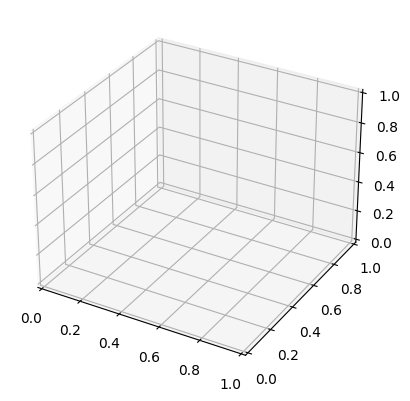

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
print(ms_x.shape,ms_t.shape)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

Plotting:

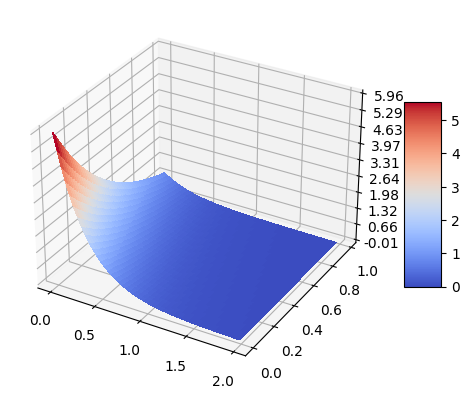

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()